# Load Libraries

In [26]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [1]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Connect to DB, load data, clean data

In [2]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [3]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
unique_deps_across_versions <- dbGetQuery(con, "
    SELECT *
    FROM analysis.unique_deps_yearly_latest --unique_deps_yearly_latest_depended_on_only, unique_deps_yearly_latest
")

In [16]:
unique_deps_across_versions$dep_type <- sapply(unique_deps_across_versions$dep_type, as.character)
unique_deps_across_versions$dep_typeFact <- as.factor(unique_deps_across_versions$dep_type)
unique_deps_across_versions$composite_constraint_type <- sapply(unique_deps_across_versions$composite_constraint_type, as.character)
unique_deps_across_versions$composite_constraint_typeFact <- as.factor(unique_deps_across_versions$composite_constraint_type)

In [17]:
unique_deps_across_versions$composite_constraint_typeFact <- fct_collapse(unique_deps_across_versions$composite_constraint_typeFact,
    "Minor (^1.2.3)"="range-minor",
    "Exact (=1.2.3)"="range-=",
    "Bug (~1.2.3)"="range-patch",
    "Any (*)"="range-major",
    "Geq (>=1.2.3)"="range->=",
    # Tag="tag",
    other_level="Other"
)

In [18]:
unique_deps_across_versions$composite_constraint_typeFact <- factor(
    unique_deps_across_versions$composite_constraint_typeFact, levels=c("Exact (=1.2.3)", "Bug (~1.2.3)", "Minor (^1.2.3)", "Geq (>=1.2.3)", "Any (*)", "Other"))

In [19]:
head(unique_deps_across_versions)

,package_id,year,dependency_id,dep_type,composite_constraint_type,dep_typeFact,composite_constraint_typeFact
,<int64>,<dbl>,<int64>,<chr>,<chr>,<fct>,<fct>
1,2096802,2016,3486,prod,range-minor,prod,Minor (^1.2.3)
2,2458610,2020,17122448,prod,range-=,prod,Exact (=1.2.3)
3,2011618,2019,454266,prod,range-minor,prod,Minor (^1.2.3)
4,2469898,2021,19674213,prod,range-minor,prod,Minor (^1.2.3)
5,2477505,2021,20825019,prod,range-minor,prod,Minor (^1.2.3)
6,1850336,2021,13588810,prod,range-=,prod,Exact (=1.2.3)


In [20]:
year_sums <- unique_deps_across_versions %>% 
    group_by(year) %>% 
    summarise(year_total=n())

In [21]:
# Get the percentage of each composite_constraint_typeFact within each year



dep_by_year_percs <- unique_deps_across_versions %>% 
    group_by(year, composite_constraint_typeFact) %>% 
    summarise(count=n()) %>% 
    inner_join(year_sums, by="year") %>%
    mutate(percentage = count / year_total)
    # mutate(percentage = count / sum(count)) 
    # %>% 
    # ggplot(aes(x=yearFact, y=percentage, fill=composite_constraint_typeFact)) +
    #     geom_bar(stat="identity") +
    #     theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    #     labs(x="Year", y="Percentage of Dependencies", fill="Constraint Type") +
    #     scale_fill_brewer(palette="Set1") +
    #     theme(legend.position="bottom")

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


In [22]:
head(dep_by_year_percs)

year,composite_constraint_typeFact,count,year_total,percentage
<dbl>,<fct>,<int>,<int>,<dbl>
2010,Exact (=1.2.3),29,188,0.15425532
2010,Geq (>=1.2.3),143,188,0.76063830
2010,Any (*),4,188,0.02127660
2010,Other,12,188,0.06382979
2011,Exact (=1.2.3),3255,13966,0.23306602
2011,Bug (~1.2.3),2840,13966,0.20335100


In [23]:
dep_by_year_percs$yearFact <- factor(dep_by_year_percs$year)

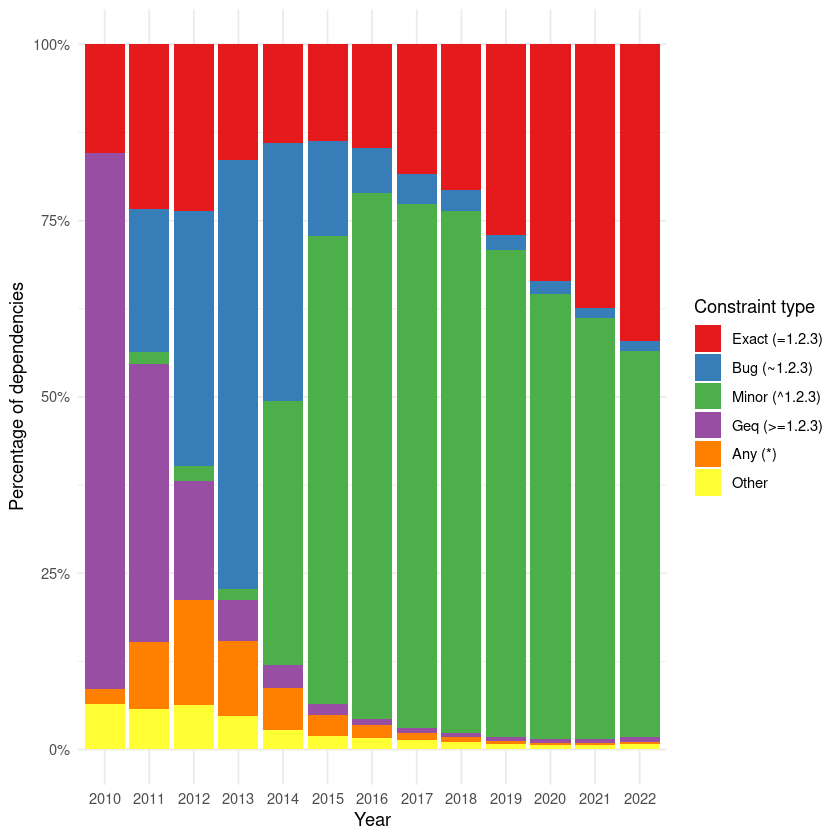

In [24]:
# plot a stacked area plot of composite_constraint_typeFact over year
ggplot(dep_by_year_percs, aes(x=yearFact, y=percentage, fill=composite_constraint_typeFact)) +
    geom_col() +
    scale_x_discrete() +
    scale_fill_brewer(palette="Set1") +
    scale_y_continuous(labels = scales::percent) + 
    theme_minimal() +
    # theme(legend.position="bottom") +
    labs(x="Year", y="Percentage of dependencies", fill="Constraint type")

In [23]:
dep_by_year_percs

year,composite_constraint_typeFact,count,year_total,percentage
<dbl>,<fct>,<int>,<int>,<dbl>
2010,exact,29,188,0.15425532
2010,geq,143,188,0.76063830
2010,major,4,188,0.02127660
2010,tag,4,188,0.02127660
2010,other,8,188,0.04255319
2011,exact,3255,13966,0.23306602
2011,geq,5501,13966,0.39388515
2011,major,1340,13966,0.09594730
2011,minor,233,13966,0.01668337


In [32]:
ggplot(data = head(unique_deps_across_versions, 1000), aes(x = year)) +
    geom_area(aes(fill = composite_constraint_typeFact), position="fill") +
    scale_x_discrete()

ERROR while rich displaying an object: Error in `geom_area()`:
! Problem while computing stat.
ℹ Error occurred in the 1st layer.
Caused by error in `compute_layer()`:
! `stat_align()` requires the following missing aesthetics: y

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

# Make plots!

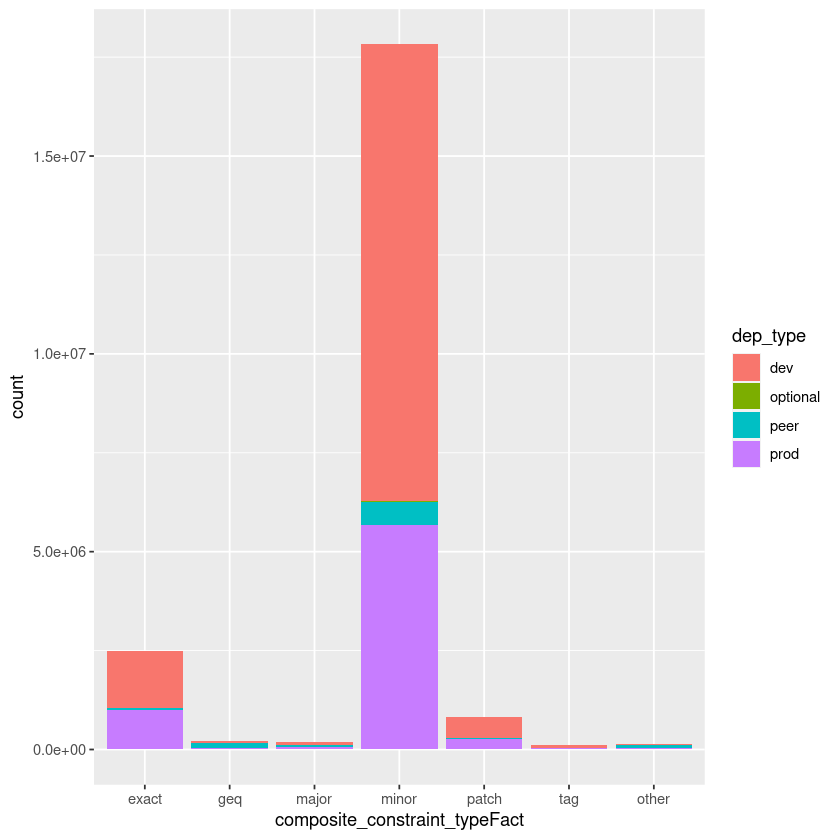

In [8]:
# Takes about 20 seconds
ggplot(data = unique_deps_across_versions, aes(x = composite_constraint_typeFact, fill=dep_type)) +
    geom_bar()

### What proportion of each package's dependency are each type?

In [9]:
# creates a data frame with one row per package, and columns for count of each update type
# constraintCountsByPackage <- 
total_unqiue_deps <- unique_deps_across_versions %>%
    group_by(package_id,composite_constraint_typeFact) %>%
    summarise(
        count = n()
    ) %>%
    group_by(package_id) %>%
    summarise(
        total = sum(count),
    )


`summarise()` has grouped output by 'package_id'. You can override using the
`.groups` argument.


In [10]:
head(total_unqiue_deps)

package_id,total
<int64>,<int>
335,53
336,33
337,6
339,106
340,134
341,98


In [11]:
constraintCountsByPackageAndDepType <- unique_deps_across_versions %>%
    group_by(package_id,composite_constraint_typeFact) %>%
    summarise(
        count = n()
    ) %>%
    inner_join(total_unqiue_deps, by=c('package_id')) %>%
    mutate(pct = count / total) %>%
    pivot_wider(names_from = composite_constraint_typeFact, values_from = c(count, pct), values_fill=0)


`summarise()` has grouped output by 'package_id'. You can override using the
`.groups` argument.


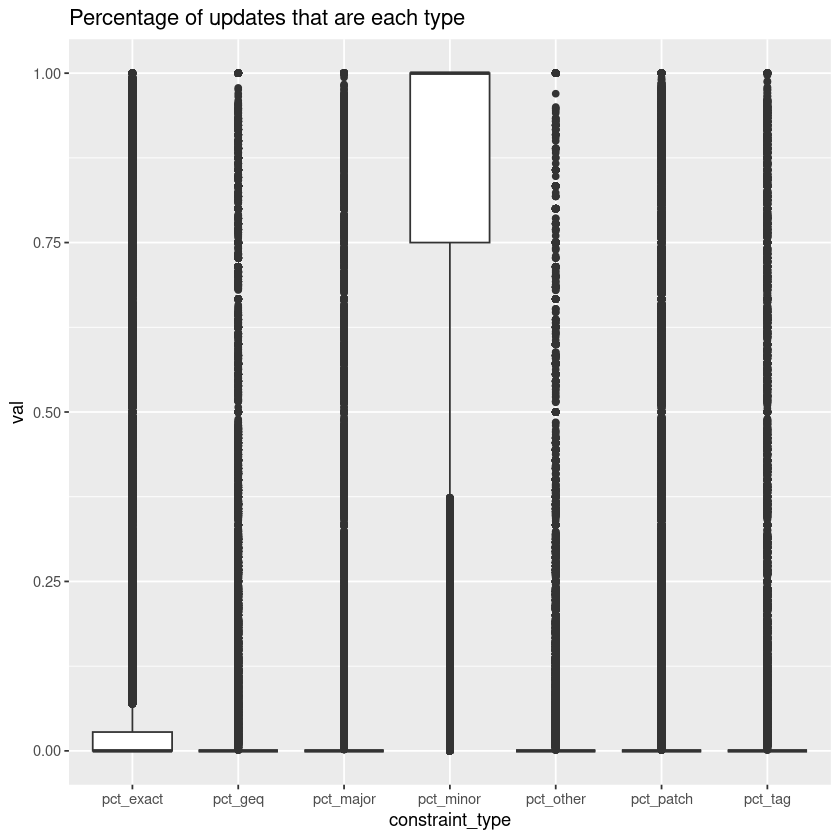

In [13]:
# box plots of the percentage of updates that are each type
ggplot(data = constraintCountsByPackageAndDepType %>% pivot_longer(cols=starts_with("pct"), names_to="constraint_type", values_to="val"), aes(x = constraint_type, y = val)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(labels=c("bug", "major", "minor", "zero")) +
    # scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(title = "Percentage of updates that are each type")

package_id,major,minor,bug,none,total,majorPct,minorPct,bugPct,nonePct
<int64>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
335,12,182,150,0,344,0.03488372,0.5290698,0.4360465,0
336,0,0,2,0,3,0.00000000,0.0000000,0.6666667,0
337,0,0,1,0,1,0.00000000,0.0000000,1.0000000,0
341,18,233,384,0,635,0.02834646,0.3669291,0.6047244,0
488,1,0,1,0,2,0.50000000,0.0000000,0.5000000,0
2580,0,1,2,0,3,0.00000000,0.3333333,0.6666667,0
